In [1]:
! ../../keras-retinanet/keras_retinanet/bin/train.py --weights ../../resnet50_coco_best_v2.1.0.h5 \
--batch-size 2 --steps 500 --epochs 30 \
--snapshot-path snapshots_roboflow1 \
--random-transform \
--config elephant_config.ini \
csv train/_annotations.csv elephant_classes.csv \
--val-annotations valid/_annotations.csv

2023-03-30 00:13:30.861044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 00:13:30.907896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 00:13:30.908247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 00:13:31.594966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/host/mids-251-elephant-seal/roboflow1/../../keras-retinanet/keras_retinanet/bin/train.py", line 34, in <module>
    from .. import layers  # noqa: F401
    ^^^^^^^^^^^^^^^^^^^^^
  File "/host/mids-251-elephant-seal/roboflow1/../../keras-retinanet/k

In [ ]:
! ../keras-retinanet/keras_retinanet/bin/convert_model.py --config config_albatross/config.ini data/snapshots_albatross/resnet50_csv_27.h5 data/snapshots_albatross/final_model_albatross.h5

In [ ]:
! ../keras-retinanet/keras_retinanet/bin/evaluate.py csv data/mosaics/albatross/labeled_tiles_albatross/albatross_test_annotations_final.csv data/mosaics/albatross/labeled_tiles_albatross/classes.csv data/snapshots_albatross/final_model_albatross.h5 

In [ ]:
! ../keras-retinanet/keras_retinanet/bin/evaluate.py csv data/mosaics/albatross/labeled_tiles_albatross/albatross_val_annotations_final.csv data/mosaics/albatross/labeled_tiles_albatross/classes.csv data/snapshots_albatross/final_model_albatross.h5

In [10]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

import keras

from keras_retinanet.models import retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json
from random import shuffle

import tensorflow as tf

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(get_session())

ModuleNotFoundError: No module named 'keras_retinanet'

In [9]:
!pip install keras_retinanet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.33-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 37.5 MB/s eta 0:00:0000:0100:01
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [92 lines of output]
      /opt/conda/envs/geo_env/lib/python3.11/site-packages/setuptools/__init__.py:85: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated. Requirements should be satisfied by a PEP 517 installer. If you are using pip, you can try `pip install --use-pep517`.
        dist.fetch_build_eggs(dist.setup_requires)
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-311
      cr

In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-03-30 00:05:35.416606: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 00:05:35.465919: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 00:05:35.466571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 00:05:36.221973: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]

In [4]:
model_path = 'data/snapshots_albatross/final_model.h5'

print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')

#print(model.summary())

labels_to_names = {0: 'albatross'}

data/snapshots_albatross/final_model.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[ -8.94     ,  -5.7216   ,   8.94     ,   5.7216   ],
       [-13.76     ,  -8.8064   ,  13.76     ,   8.8064   ],
       [-22.       , -14.08     ,  22.       ,  14.08     ],
       [ -7.152    ,  -7.152    ,   7.152    ,   7.152    ],
       [-11.008    , -11.008    ,  11.008    ,  11.008    ],
       [-17.6      , -17.6      ,  17.6      ,  17.6      ],
       [ -5.7225156,  -8.938569 ,   5.7225156,   8.938569 ],
       [ -8.80781  , -13.757799 ,   8.80781  ,  13.757799 ],
       [-14.082253 , -21.99648  ,  14.082253 ,  21.99648  ]],
      dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-17.88    , -11.4432  ,  17.88    ,  11.4432  ],
       [-27.52    , -17.6128  ,  27.52    ,  17.6128  ],
       [-44.      , -28.16    ,  44.      ,  28.16    ],
       [-14.304   , -14.304   ,  14.304   ,  14.304   ],
       [-22.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
image_dir = "data/mosaics/albatross/SteepleJason_Bubble_Nov2019_Reprocess_transparent_mosaic_group1_1000x1000_overlap60/"

image_list = []
for root, dirs, files in os.walk(image_dir):
    for filename in files:
        if filename.lower().endswith(('.png')):
            image_list.append(image_dir + filename)
print(len(image_list))

289


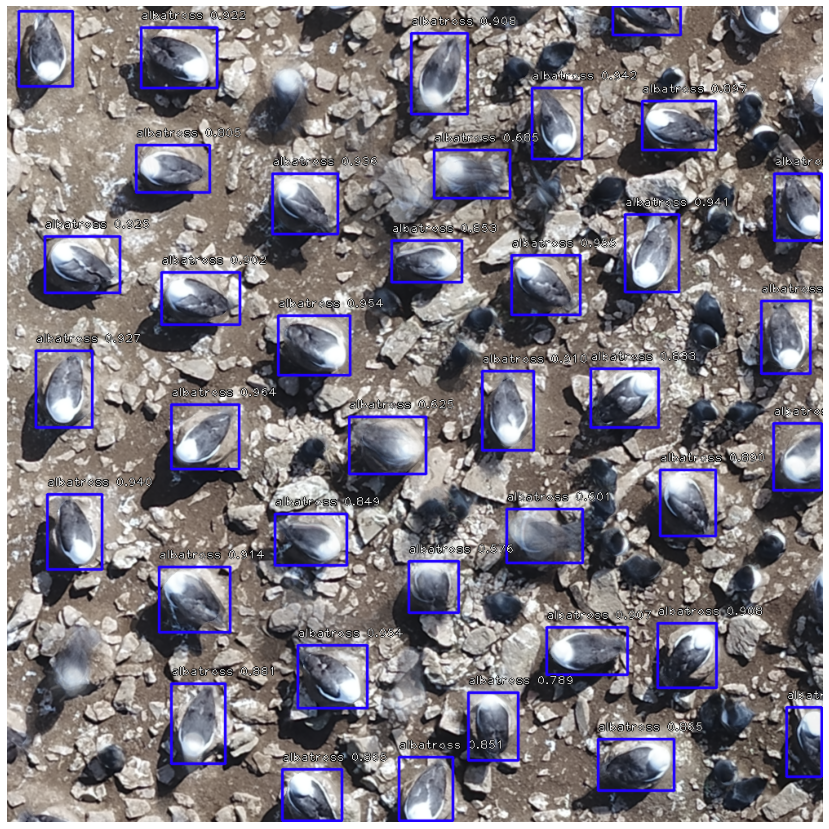

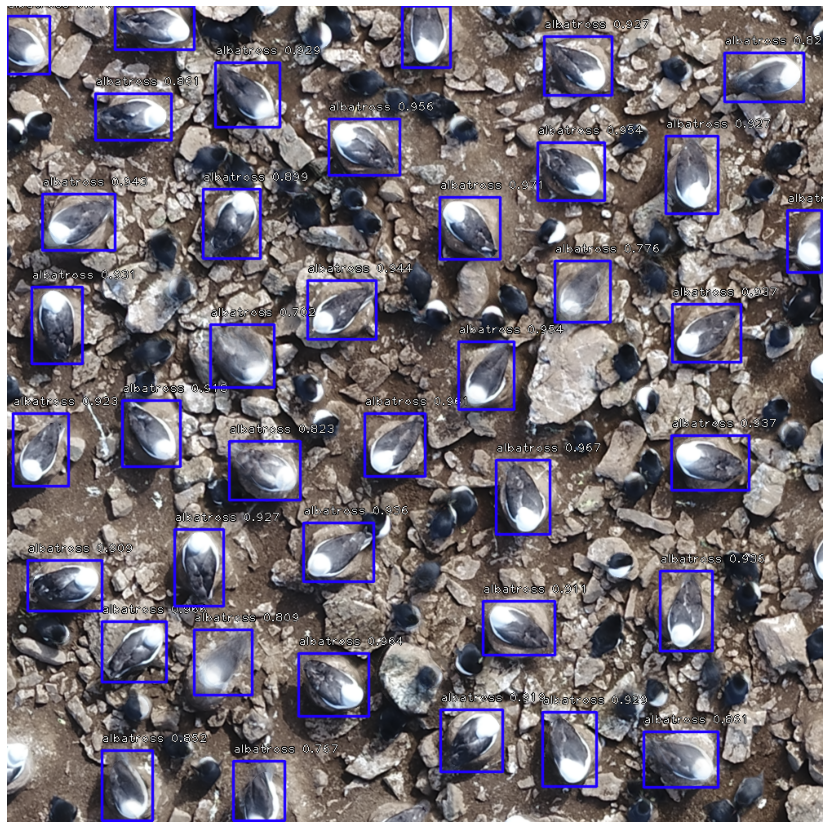

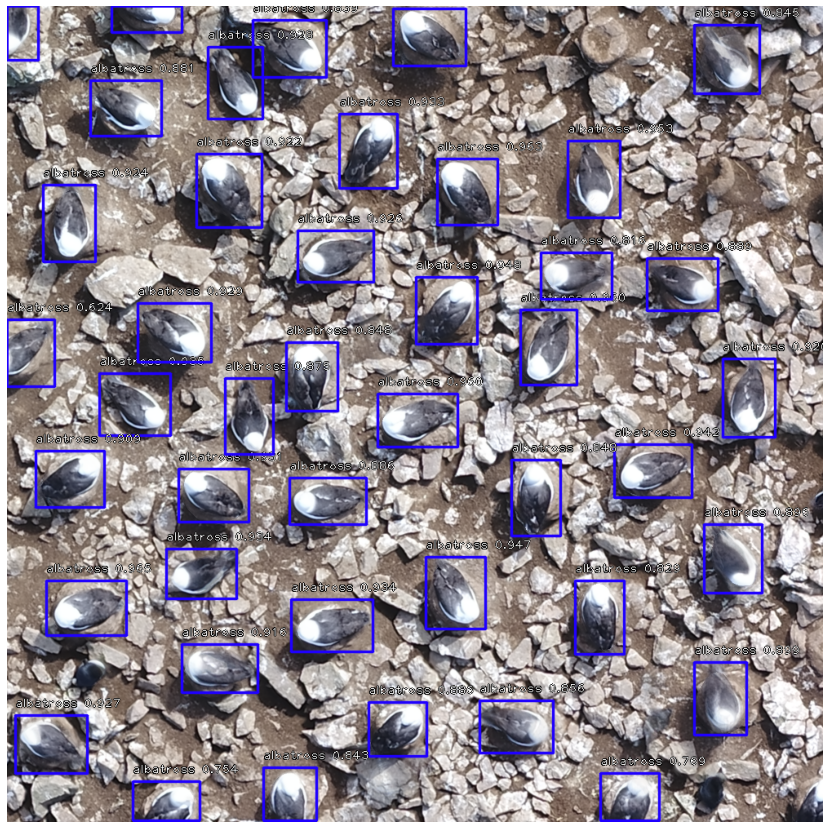

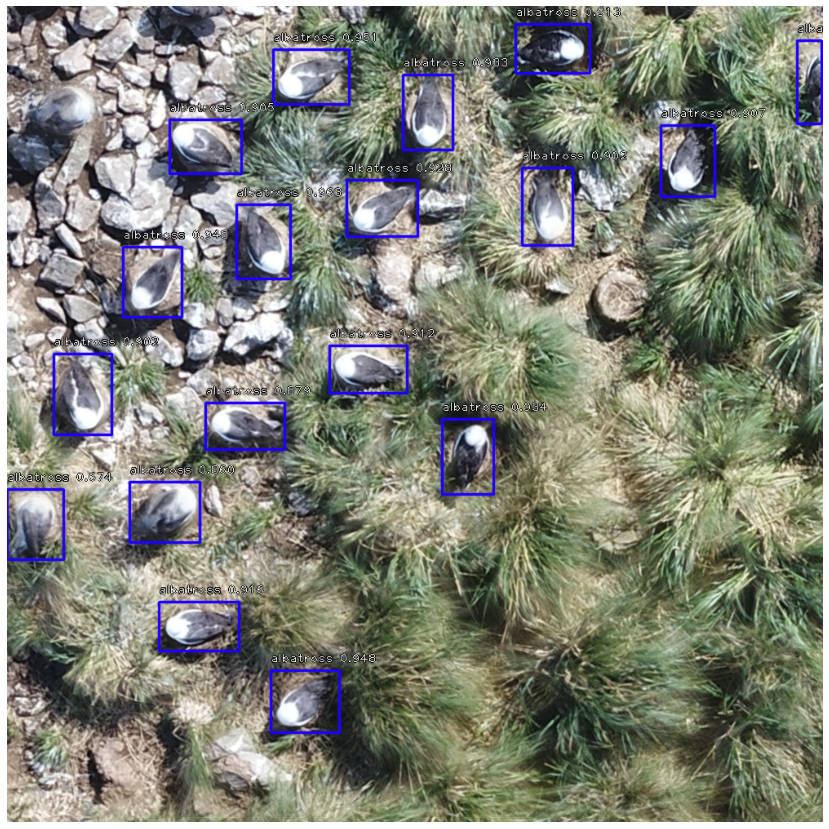

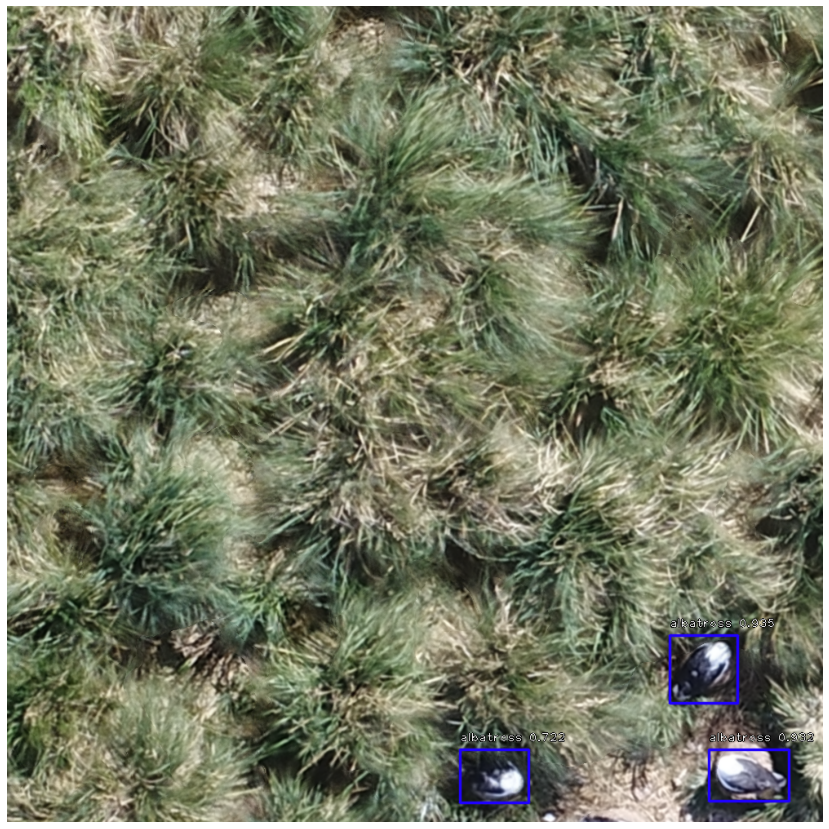

Finished, time per image: 0.019333794042725876


In [6]:
visualize = True
min_score = 0.5

detections = {}

total_time = 0

count = 0
detection_iterations = 10
shuffle(image_list)

for image_path in image_list: 
    if count > detection_iterations:
        break
    else: 
        count +=1
    
    image = read_image_bgr(image_path)
    
    if visualize:
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start 
    
    boxes /= scale
    if any(score >= min_score for score in scores [0]):
        detections[image_path] = []
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < min_score:
            break
        
        b = box.astype(int)
        detections[image_path].append({"box" : b, "label" : label, "score" : score})
        
        if visualize: 
            color = label_color(label)
            
            draw_box(draw, b, color=color)
            
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
            
    if any(score >= min_score for score in scores[0]):
        if visualize:
            plt.figure(figsize=(15, 15))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
            
print("Finished, time per image:", total_time/len(image_list))

In [59]:
min_score = 0.5

detections = {}

total_time = 0

for image_path in image_list:
    
    image = read_image_bgr(image_path)
          
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start
    
    boxes /= scale  
        
    if any(score >= min_score for score in scores[0]):
        detections[image_path] = []
        
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < min_score:
            break
        
        b = box.astype(int)    
        detections[image_path].append({"box" : b, "label" : label, "score" : score})
        
            
print("Finished, time per image:", total_time/len(image_list))

Finished, time per image: 0.11866101557339552


In [60]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [61]:
with open('data/detections_albatross/detections_steeplejason_bubble.json', 'w') as fp:
    json.dump(detections, fp, cls=MyEncoder)